In [1]:
import inspect
import logging
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import IPython

logging.basicConfig()
lg = logging.getLogger()
lg.setLevel(logging.INFO)
lg.handlers[0].setFormatter(logging.Formatter("%(asctime)s.%(msecs)03d %(pathname)s:%(lineno)d %(message)s", datefmt="%Y-%m-%d %H:%M:%S"))

plt.rcParams["font.family"]=["Noto Serif CJK JP"]

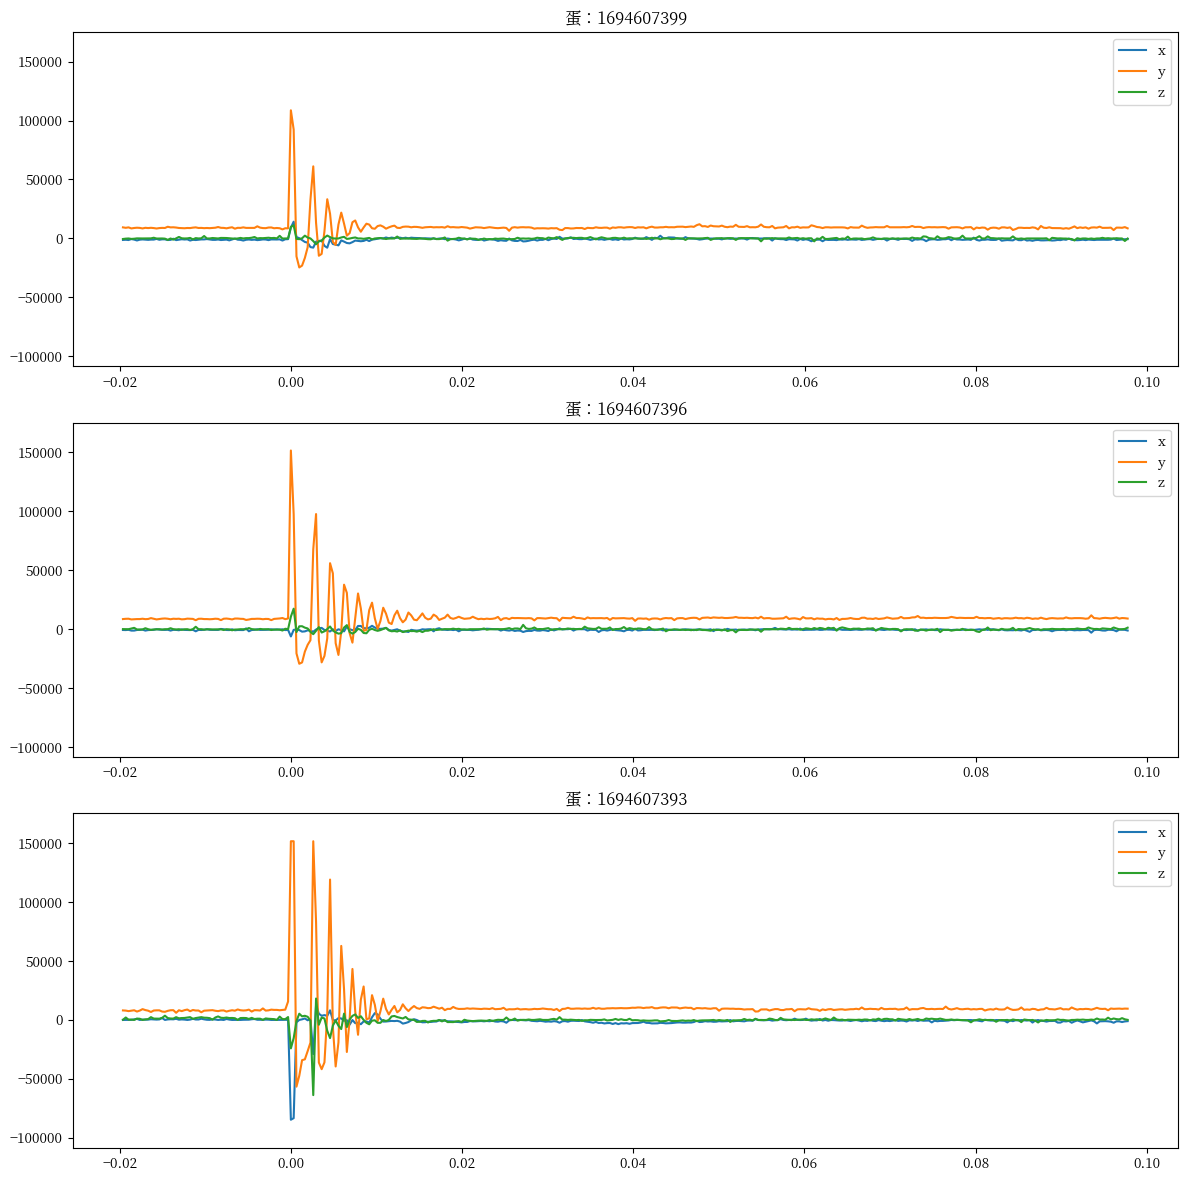

2023-09-13 20:16:40.273 /tmp/ipykernel_26924/1451600096.py:98 3 3
2023-09-13 20:16:40.774 /tmp/ipykernel_26924/1451600096.py:98 3 3
2023-09-13 20:16:41.275 /tmp/ipykernel_26924/1451600096.py:98 3 3
2023-09-13 20:16:41.776 /tmp/ipykernel_26924/1451600096.py:98 3 3
2023-09-13 20:16:42.278 /tmp/ipykernel_26924/1451600096.py:98 3 3
2023-09-13 20:16:42.779 /tmp/ipykernel_26924/1451600096.py:98 3 3
2023-09-13 20:16:43.280 /tmp/ipykernel_26924/1451600096.py:98 3 3
2023-09-13 20:16:43.781 /tmp/ipykernel_26924/1451600096.py:98 3 3
2023-09-13 20:16:44.283 /tmp/ipykernel_26924/1451600096.py:98 3 3
2023-09-13 20:16:44.784 /tmp/ipykernel_26924/1451600096.py:98 3 3
2023-09-13 20:16:45.285 /tmp/ipykernel_26924/1451600096.py:98 3 3
2023-09-13 20:16:45.786 /tmp/ipykernel_26924/1451600096.py:98 3 3
2023-09-13 20:16:46.288 /tmp/ipykernel_26924/1451600096.py:98 3 3
2023-09-13 20:16:46.788 /tmp/ipykernel_26924/1451600096.py:98 3 3
2023-09-13 20:16:47.290 /tmp/ipykernel_26924/1451600096.py:98 3 3
2023-09-13

In [ ]:
def getRange(dataPaths):
    mins, maxs = [], []
    for dataPath in dataPaths:
        data = np.loadtxt(dataPath, skiprows=1, delimiter=",", dtype=float)
        ys = data[:, 1:]
        mins.append(np.min(ys))
        maxs.append(np.max(ys))
    return [np.min(mins), np.max(maxs)]


def findSpike(data):
    y = data[:, 2]

    n = 5
    yT = y[:len(y)-n]
    yTn = y[n:]
    
    diff = yTn - yT
    thresholded = (diff > 20000)
    if np.count_nonzero(thresholded) == 0:
        return -1
    maxIdx = np.argmax(thresholded)
    return maxIdx+n


def process(dataPath):
    allData = np.loadtxt(dataPath, skiprows=1, delimiter=",", dtype=float)

    spikeT = findSpike(allData)
    if spikeT < 0:
        return None, f"no spike {inspect.getframeinfo(inspect.currentframe())}"
    # Move time zero to spikeStart and change units from seconds to milliseconds.
    allData[:, 0] -= allData[spikeT, 0]
    #allData[:, 0] *= 1000
    # Zoom into time range.
    dataPerMS = 3
    spikeStart = spikeT - 20*dataPerMS
    spikeEnd = spikeT + 100*dataPerMS
    data = allData[spikeStart:spikeEnd]

    return data, None


def plot(ax, data, dataPath, ylim):
    title = os.path.basename(dataPath)[:-4]
    
    x = data[:, 0]
    ys = [
        {"d": data[:, 1], "label": "x"},
        {"d": data[:, 2], "label": "y"},
        {"d": data[:, 3], "label": "z"},
    ]
    for y in ys:
        ax.plot(x, y["d"], label=y["label"])
    ax.set_ylim(ylim)
    ax.legend()
    ax.title.set_text(f"蛋：{title}")


def readAndPlot(dataDir):
    dataPaths = os.listdir(dataDir)
    dataPaths.sort(key=lambda x: int(x[:len(x)-4]), reverse=True)
    dataPaths = [os.path.join(dataDir, x) for x in dataPaths]
    dataset = []
    for _, dPath in enumerate(dataPaths):
        data, err = process(dPath)
        if err:
            continue
        dataset.append({"path": dPath, "data": data})
    if len(dataset) == 0:
        return
    
    allRange = getRange(dataPaths)
    range = allRange[1] - allRange[0]
    ylim = [allRange[0]-0.1*range, allRange[1]+0.1*range]
    
    fig, axes = plt.subplots(len(dataset), 1, figsize=[12, 4*len(dataset)])
    fig.tight_layout(pad=2)
    for i, dSet in enumerate(dataset):
        ax = axes
        try:
            ax = axes[i]
        except:
            pass
            
        plot(ax, dSet["data"], dSet["path"], ylim)
    IPython.display.display(fig)
    

def main():
    dataDir = "data"

    readAndPlot(dataDir)

    prevNumData = len(os.listdir(dataDir))
    while True:
        numData = len(os.listdir(dataDir))
        logging.info("%d %d", numData, prevNumData)
        if numData == prevNumData:
            time.sleep(0.5)
            continue
        prevNumData = numData

        IPython.display.clear_output(wait=True)
        readAndPlot(dataDir)


main()